# Alpha Excel v2.0 Tutorial

이 노트북은 alpha-excel v2.0의 핵심 기능을 간단하게 소개합니다.

## 주요 특징
- **즉시 실행 (Eager Execution)**: 연산이 즉시 실행됨
- **타입 인식 시스템**: numeric, group, weight, mask 타입별 자동 전처리
- **메서드 기반 API**: import 없이 IDE 자동완성 지원
- **캐시 상속**: 상위 단계의 캐시를 하위 단계에서 접근 가능
- **설정 기반 설계**: YAML 파일로 동작 제어

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from alpha_excel2.core.facade import AlphaExcel

## 1. AlphaExcel 초기화

시작일과 종료일을 지정하여 AlphaExcel 인스턴스를 생성합니다.

In [2]:
ae = AlphaExcel(
    start_time='2016-01-28',
    end_time='2025-09-30',
    universe=None,
    config_path='../config'
)

print(f"Time Range: {ae._start_time} to {ae._end_time}")
print(f"Universe Shape: {ae._universe_mask._data.shape}")

Config file not found: ..\config\preprocessing.yaml. Using empty config.


Time Range: 2016-01-28 00:00:00 to 2025-09-30 00:00:00
Universe Shape: (2375, 2996)


## 2. 사용 가능한 연산자 확인

카테고리별로 등록된 연산자를 확인합니다.

In [3]:
o = ae.ops

by_category = o.list_operators_by_category()
for category, ops in sorted(by_category.items()):
    print(f"\n{category}:")
    for op in ops:
        print(f"  - {op}")


arithmetic:
  - abs
  - add
  - divide
  - log
  - multiply
  - negate
  - power
  - sign
  - subtract

conditional:
  - if_else

crosssection:
  - mean
  - rank
  - scale
  - zscore

group:
  - group_count
  - group_max
  - group_min
  - group_neutralize
  - group_rank
  - group_scale
  - group_sum

logical:
  - and
  - equal
  - greater_or_equal
  - greater_than
  - less_or_equal
  - less_than
  - not
  - not_equal
  - or

reduction:
  - cross_mean
  - cross_median
  - cross_std
  - cross_sum

timeseries:
  - ts_all
  - ts_any
  - ts_arg_max
  - ts_arg_min
  - ts_corr
  - ts_count_nans
  - ts_covariance
  - ts_delay
  - ts_delta
  - ts_max
  - ts_mean
  - ts_min
  - ts_product
  - ts_std_dev
  - ts_sum
  - ts_zscore


## 3. 데이터 필드 로딩

서로 다른 타입의 필드를 로딩합니다:
- `fnguide_market_cap`: numeric 타입 (시가총액)
- `returns`: numeric 타입 (수익률)
- `fnguide_sector`: group 타입 (섹터)
- `fnguide_sales`: numeric 타입 (매출액)

In [4]:
f = ae.field

# 시가총액 로딩
cap = f('fnguide_market_cap')
print("[Market Cap]")
print(f"Data type: {cap._data_type}")
print(cap.to_df().iloc[:10, :5])

[Market Cap]
Data type: numeric
symbol           A000020       A000030       A000040       A000050  \
date                                                                 
2016-01-28  2.457970e+11  5.854160e+12  2.094930e+11  5.277440e+11   
2016-01-29  2.536180e+11  5.948800e+12  2.103690e+11  5.483050e+11   
2016-02-01  2.628350e+11  5.975840e+12  2.051100e+11  5.359690e+11   
2016-02-02  2.558520e+11  5.955560e+12  2.024800e+11  5.537880e+11   
2016-02-03  2.656280e+11  5.800080e+12  2.059870e+11  5.565300e+11   
2016-02-04  2.572490e+11  5.948800e+12  2.086160e+11  5.551590e+11   
2016-02-05  2.656280e+11  6.070480e+12  2.094930e+11  5.647550e+11   
2016-02-11  2.404900e+11  5.806840e+12  1.972210e+11  5.633840e+11   
2016-02-12  2.153520e+11  5.766280e+12  1.937150e+11  5.579010e+11   
2016-02-15  2.242900e+11  5.955560e+12  2.007270e+11  5.387100e+11   

symbol           A000060  
date                      
2016-01-28  1.557656e+12  
2016-01-29  1.584147e+12  
2016-02-01  1.58944

In [5]:
# 수익률 로딩
ret = f('returns')
print("[Returns]")
print(f"Data type: {ret._data_type}")

# 섹터 로딩
sector = f('fnguide_industry_group')
print("[Sector]")
print(f"Data type: {sector._data_type}")

# 매출액 로딩
sales = f('fnguide_sales')
print("[Sales]")
print(f"Data type: {sales._data_type}")

# 월말 거래량 로딩
monthend_volume = f('monthly_trading_volume')
print("[Monthly Trading Volume]")
print(f"Data type: {monthend_volume._data_type}")

[Returns]
Data type: numeric
[Sector]
Data type: group
[Sector]
Data type: group
[Sales]
Data type: numeric
[Sales]
Data type: numeric
[Monthly Trading Volume]
Data type: numeric
[Monthly Trading Volume]
Data type: numeric


## 4. 시계열 연산 및 모멘텀 시그널 생성

이동평균을 계산하고 모멘텀 시그널을 생성합니다.

In [6]:
# 3일 이동평균 (캐시 기록)
ma3 = o.ts_mean(ret, window=3, record_output=True)

# 5일 이동평균
ma5 = o.ts_mean(ret, window=5)

# 모멘텀 = ma3 - ma5
momentum = ma3 - ma5

print("[모멘텀 시그널]")
print(momentum.to_df().iloc[:10, :5])

[모멘텀 시그널]
symbol       A000020   A000030   A000040   A000050   A000060
date                                                        
2016-01-28       NaN       NaN       NaN       NaN       NaN
2016-01-29  0.000000  0.000000  0.000000  0.000000  0.000000
2016-02-01  0.000000  0.000000  0.000000  0.000000  0.000000
2016-02-02  0.001462 -0.002665 -0.008148  0.012914 -0.001683
2016-02-03 -0.001569 -0.009847 -0.007841  0.001318 -0.006085
2016-02-04 -0.016286 -0.004657  0.006470  0.001473 -0.005379
2016-02-05  0.003276  0.002435  0.012131  0.000487  0.005586
2016-02-11 -0.014810  0.006256 -0.006459 -0.005987  0.004434
2016-02-12 -0.023545 -0.003902 -0.015640  0.000186 -0.002026
2016-02-15 -0.021227 -0.011564 -0.008739 -0.009172 -0.002012


## 5. 그룹 연산: 섹터 내 순위

각 섹터 내에서 모멘텀 시그널의 순위를 계산합니다.

In [7]:
signal = o.group_rank(momentum, sector)

print("[그룹 순위 시그널]")
print(signal.to_df().iloc[:10, :5])

[그룹 순위 시그널]
symbol       A000020   A000030   A000040   A000050   A000060
date                                                        
2016-01-28       NaN       NaN       NaN       NaN       NaN
2016-01-29       NaN       NaN       NaN       NaN       NaN
2016-02-01  0.503704  0.541667  0.503704  0.504762  0.533333
2016-02-02  0.629630  0.750000  0.170370  0.952381  0.666667
2016-02-03  0.481481  0.750000  0.340741  0.647619  0.666667
2016-02-04  0.170370  0.500000  0.755556  0.647619  0.466667
2016-02-05  0.822222  0.333333  0.888889  0.447619  0.733333
2016-02-11  0.385185  0.666667  0.185185  0.314286  0.666667
2016-02-12  0.244444  0.500000  0.214815  0.914286  0.600000
2016-02-15  0.125926  0.333333  0.429630  0.495238  0.866667


## 6. 시그널 히스토리 및 캐시 확인

각 단계의 연산 히스토리와 캐시를 확인합니다.

In [8]:
# 마지막 단계의 히스토리
print("\n마지막 단계:")
print(signal._step_history[-1])


마지막 단계:
{'step': 3, 'expr': 'GroupRank((TsMean(Field(returns), window=3) - TsMean(Field(returns), window=5)), Field(fnguide_industry_group))', 'op': 'GroupRank'}


In [9]:
# 캐시 정보
print("[캐시 정보]")
print(f"단계 카운터: {signal._step_counter}")
print(f"캐시 크기: {len(signal._cache)}")
print(f"\n캐시된 단계:")
signal._cache

[캐시 정보]
단계 카운터: 3
캐시 크기: 1

캐시된 단계:


[CachedStep(step=1, name='TsMean(Field(returns), window=3)', data=symbol       A000020   A000030   A000040   A000050   A000060   A000070  \
 date                                                                     
 2016-01-28  0.008018  0.016432  0.021381 -0.035088  0.006849  0.012308   
 2016-01-29  0.019918  0.016299  0.012779  0.001937  0.011928  0.038069   
 2016-02-01  0.025393  0.012381  0.000184 -0.006209  0.009067  0.040617   
 2016-02-02  0.013865  0.005773 -0.011209  0.016570  0.000117  0.036515   
 2016-02-03  0.015995 -0.008318 -0.006823  0.005233 -0.003284  0.004309   
 ...              ...       ...       ...       ...       ...       ...   
 2025-09-24  0.002667       NaN -0.008319 -0.000377       NaN -0.003498   
 2025-09-25  0.004764       NaN -0.001289 -0.005063       NaN -0.010725   
 2025-09-26 -0.004158       NaN  0.014950 -0.004199       NaN -0.014812   
 2025-09-29  0.000035       NaN  0.013140 -0.000440       NaN -0.000971   
 2025-09-30 -0.002561       NaN  0.

## 7. 백테스팅: 가중치 스케일러 설정

DollarNeutral 스케일러를 사용하여 롱-숏 포트폴리오를 구성합니다.

In [10]:
# 스케일러 설정
ae.set_scaler('DollarNeutral')

print("[스케일러 설정]")
print(f"스케일러 타입: {ae._scaler_manager._active_scaler.__class__.__name__}")
print(f"총 익스포저: {ae._scaler_manager._active_scaler.gross}")
print(f"순 익스포저: {ae._scaler_manager._active_scaler.net}")

[스케일러 설정]
스케일러 타입: DollarNeutralScaler
총 익스포저: 2.0
순 익스포저: 0.0


## 8. 시그널을 가중치로 변환

시그널을 포트폴리오 가중치로 변환합니다.

In [11]:
weights = ae.to_weights(signal)

print("[포트폴리오 가중치]")
print(weights.to_df().iloc[:10, :5])

# 가중치 검증
weights_df = weights.to_df()
print(f"\n평균 총 익스포저: {weights_df.abs().sum(axis=1).mean():.4f}")
print(f"평균 순 익스포저: {weights_df.sum(axis=1).mean():.6f}")

[포트폴리오 가중치]
symbol       A000020   A000030   A000040   A000050   A000060
date                                                        
2016-01-28  0.000000  0.000000  0.000000  0.000000  0.000000
2016-01-29  0.000000  0.000000  0.000000  0.000000  0.000000
2016-02-01 -0.000625  0.007853 -0.000625 -0.000388  0.005992
2016-02-02  0.000512  0.001013 -0.001398  0.001855  0.000666
2016-02-03 -0.000104  0.001013 -0.000689  0.000587  0.000666
2016-02-04 -0.001398 -0.000027  0.001036  0.000587 -0.000166
2016-02-05  0.001313 -0.000720  0.001591 -0.000245  0.000944
2016-02-11 -0.000505  0.000666 -0.001336 -0.000799  0.000666
2016-02-12 -0.001090 -0.000027 -0.001213  0.001696  0.000389
2016-02-15 -0.001583 -0.000720 -0.000320 -0.000047  0.001498

평균 총 익스포저: 1.9983
평균 순 익스포저: -0.000000


## 9. 포트폴리오 수익률 계산

가중치와 수익률을 곱하여 포트폴리오 수익률을 계산합니다.

In [12]:
port_returns = ae.to_portfolio_returns(weights)

print("[포트폴리오 수익률]")
print(port_returns.to_df().iloc[:10, :5])

[포트폴리오 수익률]
symbol       A000020       A000030   A000040       A000050   A000060
date                                                                
2016-01-28       NaN           NaN       NaN           NaN       NaN
2016-01-29  0.000000  0.000000e+00  0.000000  0.000000e+00  0.000000
2016-02-01  0.000000  0.000000e+00 -0.000000 -0.000000e+00  0.000000
2016-02-02  0.000017 -2.665156e-05  0.000008 -1.290716e-05 -0.000120
2016-02-03  0.000020 -2.644113e-05 -0.000024  9.181146e-06  0.000005
2016-02-04  0.000003  2.596894e-05 -0.000009 -1.445703e-06  0.000002
2016-02-05 -0.000046 -5.530201e-07  0.000004  1.014491e-05 -0.000001
2016-02-11 -0.000124  3.128212e-05 -0.000093  5.944597e-07  0.000003
2016-02-12  0.000053 -4.653180e-06  0.000024  7.780809e-06 -0.000007
2016-02-15 -0.000045 -8.874831e-07 -0.000044 -5.834259e-05  0.000003


## 10. 롱/숏 수익률 분리

롱 포지션과 숏 포지션의 수익률을 각각 계산합니다.

In [13]:
long_returns = ae.to_long_returns(weights)
short_returns = ae.to_short_returns(weights)

print("[롱 포지션 수익률]")
print(long_returns.to_df().iloc[:10, :5])

print("\n[숏 포지션 수익률]")
print(short_returns.to_df().iloc[:10, :5])

[롱 포지션 수익률]
symbol       A000020   A000030   A000040   A000050   A000060
date                                                        
2016-01-28       NaN       NaN       NaN       NaN       NaN
2016-01-29  0.000000  0.000000  0.000000  0.000000  0.000000
2016-02-01  0.000000  0.000000 -0.000000 -0.000000  0.000000
2016-02-02 -0.000000 -0.000027 -0.000000  0.000000 -0.000120
2016-02-03  0.000020 -0.000026  0.000000  0.000009  0.000005
2016-02-04 -0.000000  0.000026  0.000000 -0.000001  0.000002
2016-02-05  0.000000  0.000000  0.000004  0.000010  0.000000
2016-02-11 -0.000124 -0.000000 -0.000093 -0.000000  0.000003
2016-02-12 -0.000000 -0.000005 -0.000000 -0.000000 -0.000007
2016-02-15  0.000000  0.000000  0.000000 -0.000058  0.000003

[숏 포지션 수익률]
symbol       A000020       A000030   A000040       A000050   A000060
date                                                                
2016-01-28       NaN           NaN       NaN           NaN       NaN
2016-01-29  0.000000  0.000000e+00  

## 11. 누적 수익률 및 성과 분석

전체, 롱, 숏 포트폴리오의 누적 수익률을 계산하고 시각화합니다.

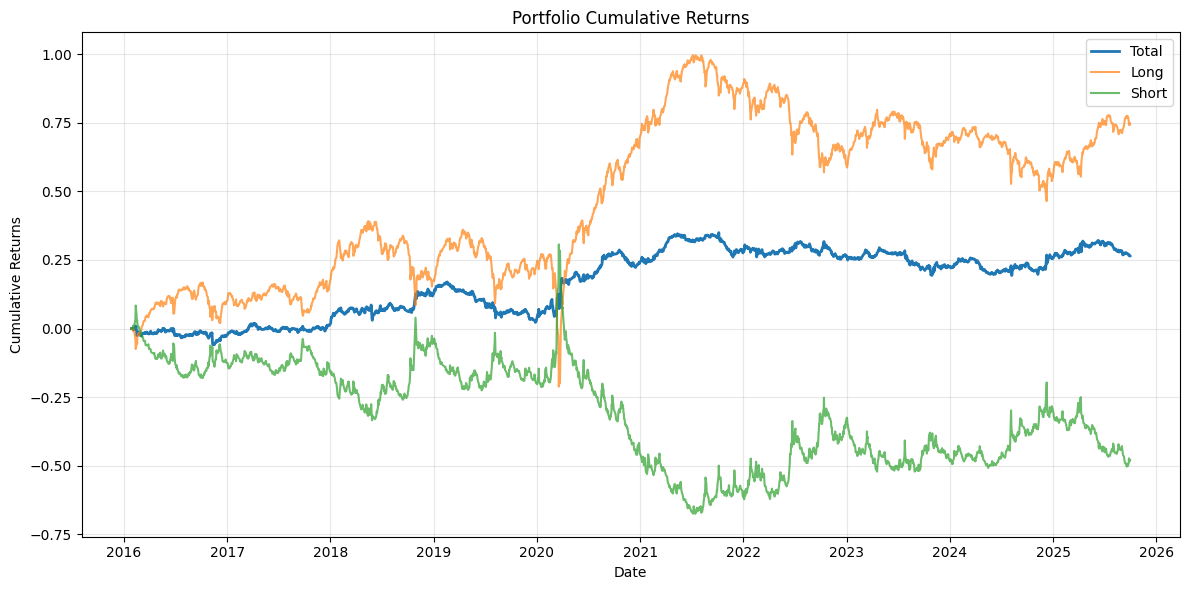

In [14]:
# 일별 수익률 합산
daily_pnl = port_returns.to_df().sum(axis=1)
long_daily_pnl = long_returns.to_df().sum(axis=1)
short_daily_pnl = short_returns.to_df().sum(axis=1)

# 누적 수익률
cum_pnl = daily_pnl.cumsum()
long_cum_pnl = long_daily_pnl.cumsum()
short_cum_pnl = short_daily_pnl.cumsum()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(cum_pnl.index, cum_pnl.values, label='Total', linewidth=2)
plt.plot(long_cum_pnl.index, long_cum_pnl.values, label='Long', linewidth=1.5, alpha=0.7)
plt.plot(short_cum_pnl.index, short_cum_pnl.values, label='Short', linewidth=1.5, alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Cumulative Returns')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. 성과 지표

연율화된 수익률, 변동성, 샤프 비율을 계산합니다.

In [15]:
# 성과 지표 계산 (전체 포트폴리오)
annualized_return = daily_pnl.mean() * 252
annualized_std = daily_pnl.std() * np.sqrt(252)
sharpe_ratio = daily_pnl.mean() / daily_pnl.std() * np.sqrt(252)

print("[성과 지표 - 전체 포트폴리오]")
print(f"연율화 수익률: {annualized_return:.4f} ({annualized_return*100:.2f}%)")
print(f"연율화 변동성: {annualized_std:.4f} ({annualized_std*100:.2f}%)")
print(f"샤프 비율: {sharpe_ratio:.2f}")
print(f"\n총 수익률: {cum_pnl.iloc[-1]:.4f} ({cum_pnl.iloc[-1]*100:.2f}%)")
print(f"최대 낙폭: {(cum_pnl - cum_pnl.cummax()).min():.4f}")

[성과 지표 - 전체 포트폴리오]
연율화 수익률: 0.0281 (2.81%)
연율화 변동성: 0.0819 (8.19%)
샤프 비율: 0.34

총 수익률: 0.2649 (26.49%)
최대 낙폭: -0.1562


## 요약

이 튜토리얼에서 다룬 내용:

1. ✅ AlphaExcel 초기화 및 설정
2. ✅ 연산자 탐색 (메서드 기반 API)
3. ✅ 다양한 타입의 데이터 필드 로딩
4. ✅ 시계열 연산 (이동평균)
5. ✅ 그룹 연산 (섹터 내 순위)
6. ✅ 캐시 상속 및 히스토리 추적
7. ✅ 백테스팅 (가중치 스케일링)
8. ✅ 포트폴리오 수익률 계산
9. ✅ 롱/숏 수익률 분리 분석
10. ✅ 성과 지표 계산 및 시각화

Alpha Excel v2.0의 주요 장점:
- 🚀 즉시 실행으로 빠른 프로토타이핑
- 🎯 타입 인식 시스템으로 자동 전처리
- 💡 메서드 기반 API로 편리한 사용
- 🔍 캐시 상속으로 디버깅 용이
- ⚙️ 설정 기반 설계로 유연한 커스터마이징